<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set()

In [3]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 1.9 MB/s 


In [4]:
from pymer4.models import Lmer

In [5]:
!pip install -q statsmodels

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘xtable’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f03e85d6410> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R 
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




## Uploading data

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
working_path = Path('/content/drive/MyDrive/CoganLab')

In [293]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_no_outliers.csv'),
    index_col=None
)

In [90]:
ieeg_extended = pd.read_csv(
    working_path.joinpath('ieeg_extended.csv'),
    index_col=None
)

In [14]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_no_outliers.csv'),
    index_col=None
)

In [15]:
new_subject = scipy.io.loadmat(
    working_path.joinpath('D72_Block_1_TrialData.mat')
    )

In [91]:
ieeg_extended = ieeg_extended[[
                              'Trial', 'block', 'ProbeType',
                              'probeSound_idx', 'StimlusCategory', 'ReactionTime',
                              'RespCorrect', 'Omission', 'ProbeCategory',
                              'stimulusSounds_idx', 'Position', 'Length',
                              'stdRT', 'Lex', 'Phono', 'Subject'
]]

## EEG dataset

In [145]:
eeg_data = eeg[[
                'Trial', 'Subject', 'Block',
                'ProbeType', 'stdRT', 'ResponseCorrect',
                'Position', 'Length', 'Lex', 'Phono'
]]

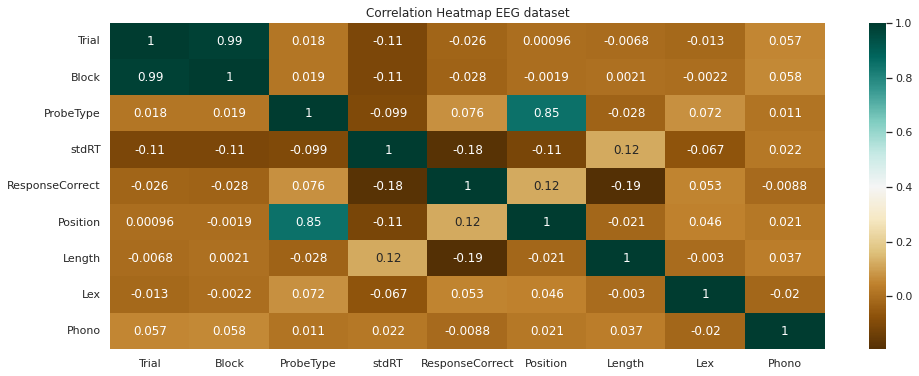

In [176]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap EEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


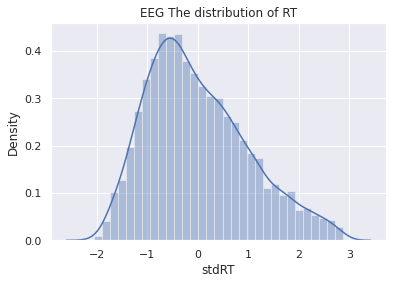

In [177]:
sns.distplot(eeg_data.stdRT)
pl.title('EEG The distribution of RT');

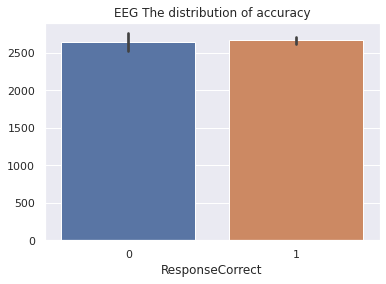

In [178]:
sns.barplot(
    x = eeg_data.ResponseCorrect,
    y = eeg_data.index
    )
pl.title('EEG The distribution of accuracy');

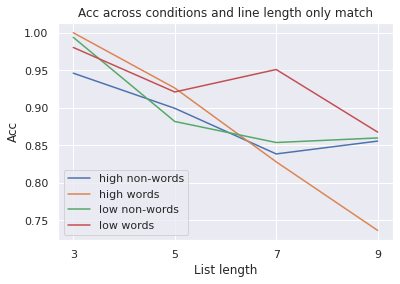

In [85]:
pl.figure()
subset = eeg[eeg['ProbeType'] == 2].groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match');

In [179]:
xx = eeg[(eeg['ProbeType'] == 2) & (eeg['Length'] == 9) & (eeg['ProbeCategory'] == 'low words')]
xx.groupby(['Subject'])[['ResponseCorrect']].mean()

,ResponseCorrect
Subject,
E10,0.600
E11,1.000
E12,0.600
E13,1.000
E15,0.800
E16,1.000
E17,1.000
E18,0.800
E2,0.800


**Models**

Full model with all IVs: lex, phono, length, probe, position.

In [181]:
model_full = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1548.187 	 AIC: 3096.374

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.961,0.921,1.002,0.020,900.639,46.928,0.00,***
Lex,0.031,0.014,0.048,0.009,5301.598,3.521,0.00,***
Phono,-0.001,-0.019,0.016,0.009,5302.036,-0.164,0.87,
Length,-0.028,-0.032,-0.024,0.002,5301.443,-14.414,0.00,***
ProbeType,0.045,0.028,0.063,0.009,5307.696,5.140,0.00,***


In [184]:
model_full1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.591 	 AIC: 3115.182

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.043,0.952,1.135,0.047,4687.303,22.328,0.000,***
Lex,0.121,0.047,0.195,0.038,5295.857,3.200,0.001,**
Phono,-0.120,-0.194,-0.046,0.038,5296.443,-3.167,0.002,**
Length,-0.039,-0.052,-0.026,0.007,5301.324,-5.767,0.000,***
ProbeType,-0.014,-0.069,0.040,0.028,5301.021,-0.511,0.609,
Lex:Phono,-0.009,-0.043,0.026,0.018,5297.637,-0.487,0.626,
Lex:Length,-0.004,-0.012,0.004,0.004,5295.605,-0.990,0.322,
Lex:ProbeType,-0.041,-0.075,-0.006,0.018,5296.787,-2.322,0.020,*
Phono:Length,0.002,-0.005,0.010,0.004,5298.372,0.623,0.534,
Phono:ProbeType,0.072,0.037,0.106,0.018,5295.726,4.072,0.000,***


In [300]:
model_full2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Lex*Length*ProbeType + Phono*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Lex*Length*ProbeType+Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1560.294 	 AIC: 3120.589

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.987,0.854,1.121,0.068,5219.506,14.527,0.000,***
Lex,0.070,-0.097,0.238,0.085,5294.361,0.825,0.409,
Phono,0.180,0.007,0.353,0.088,5293.853,2.039,0.041,*
Length,-0.036,-0.057,-0.015,0.010,5294.441,-3.437,0.001,***
ProbeType,0.017,-0.068,0.102,0.043,5293.520,0.383,0.701,
Lex:Phono,-0.244,-0.390,-0.098,0.075,5296.593,-3.275,0.001,**
Lex:Length,0.018,-0.007,0.043,0.013,5293.447,1.433,0.152,
Lex:ProbeType,0.009,-0.095,0.112,0.053,5294.217,0.162,0.872,
Phono:Length,-0.033,-0.059,-0.008,0.013,5293.291,-2.545,0.011,*
Phono:ProbeType,-0.107,-0.212,-0.002,0.054,5292.321,-1.999,0.046,*


In [301]:
model_full3 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Length*ProbeType + Lex*Phono*ProbeType + Phono*Length*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full3.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Length*ProbeType+Lex*Phono*ProbeType+Phono*Length*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1558.639 	 AIC: 3117.278

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.087,0.940,1.234,0.075,5263.407,14.496,0.000,***
Lex,-0.128,-0.336,0.080,0.106,5295.322,-1.204,0.229,
Phono,-0.045,-0.268,0.178,0.114,5295.041,-0.394,0.694,
Length,-0.053,-0.076,-0.030,0.012,5292.822,-4.485,0.000,***
ProbeType,-0.051,-0.146,0.044,0.048,5292.527,-1.055,0.291,
Lex:Phono,0.204,-0.112,0.520,0.161,5296.754,1.263,0.207,
Lex:Length,0.052,0.019,0.084,0.017,5293.682,3.105,0.002,**
Lex:ProbeType,0.142,0.009,0.275,0.068,5294.918,2.098,0.036,*
Phono:Length,0.004,-0.031,0.039,0.018,5293.950,0.221,0.825,
Phono:ProbeType,0.042,-0.098,0.182,0.072,5293.421,0.585,0.559,


**Without Probe**

In [190]:
model_noprobe = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe.fit()

Formula: ResponseCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.557 	 AIC: 3115.114

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.030,0.999,1.060,0.016,340.803,66.000,0.000,***
Lex,0.034,0.017,0.052,0.009,5302.483,3.896,0.000,***
Phono,-0.001,-0.018,0.017,0.009,5303.026,-0.091,0.927,
Length,-0.029,-0.032,-0.025,0.002,5302.461,-14.531,0.000,***


In [191]:
model_noprobe1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1569.380 	 AIC: 3138.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.022,0.977,1.067,0.023,1310.497,44.771,0.000,***
Lex,0.058,0.006,0.110,0.026,5299.721,2.194,0.028,*
Phono,-0.008,-0.060,0.045,0.027,5300.756,-0.284,0.776,
Length,-0.028,-0.034,-0.021,0.003,5300.507,-8.255,0.000,***
Lex:Phono,-0.004,-0.039,0.031,0.018,5301.768,-0.227,0.820,
Lex:Length,-0.004,-0.011,0.004,0.004,5299.611,-0.915,0.360,
Phono:Length,0.001,-0.006,0.009,0.004,5302.158,0.378,0.705,


In [192]:
model_noprobe2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1572.609 	 AIC: 3145.218

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.009,0.960,1.059,0.025,1772.892,39.921,0.000,***
Lex,0.083,0.016,0.150,0.034,5299.214,2.444,0.015,*
Phono,0.020,-0.050,0.091,0.036,5300.981,0.568,0.570,
Length,-0.025,-0.033,-0.018,0.004,5300.231,-6.678,0.000,***
Lex:Phono,-0.060,-0.159,0.039,0.051,5299.982,-1.181,0.238,
Lex:Length,-0.008,-0.018,0.003,0.005,5299.286,-1.469,0.142,
Phono:Length,-0.003,-0.014,0.008,0.006,5301.679,-0.566,0.572,
Lex:Phono:Length,0.009,-0.006,0.025,0.008,5299.852,1.176,0.240,


**Model with Match vs. mismatch**

In [57]:
match = eeg_data[eeg_data['ProbeType'] == 2]
mismatch = eeg_data[eeg_data['ProbeType'] == 1]

In [58]:
# model for MATCH
model_match = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=match
)
model_match.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2713	 Groups: {'Subject': 29.0}

Log-likelihood: -528.742 	 AIC: 1057.484

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.986,0.920,1.052,0.034,1233.157,29.156,0.000,***
Lex,0.158,0.072,0.244,0.044,2678.360,3.602,0.000,***
Phono,0.041,-0.048,0.130,0.045,2677.237,0.901,0.368,
Length,-0.017,-0.026,-0.007,0.005,2679.214,-3.337,0.001,***
Lex:Phono,-0.166,-0.290,-0.041,0.064,2677.918,-2.609,0.009,**
Phono:Length,-0.005,-0.019,0.009,0.007,2677.539,-0.674,0.500,
Lex:Length,-0.028,-0.042,-0.015,0.007,2678.116,-4.102,0.000,***
Lex:Phono:Length,0.035,0.015,0.055,0.010,2677.405,3.506,0.000,***


In [59]:
# model for MISMATCH
model_mis = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=mismatch
)
model_mis.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2621	 Groups: {'Subject': 29.0}

Log-likelihood: -942.322 	 AIC: 1884.644

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.079
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.032,0.958,1.106,0.038,698.496,27.298,0.000,***
Lex,0.016,-0.082,0.115,0.050,2587.954,0.322,0.747,
Phono,0.004,-0.103,0.110,0.054,2589.062,0.069,0.945,
Length,-0.034,-0.045,-0.023,0.006,2586.367,-6.201,0.000,***
Lex:Phono,0.019,-0.133,0.170,0.077,2589.333,0.239,0.811,
Phono:Length,-0.002,-0.018,0.015,0.008,2588.675,-0.178,0.859,
Lex:Length,0.012,-0.004,0.027,0.008,2587.082,1.460,0.144,
Lex:Phono:Length,-0.014,-0.038,0.009,0.012,2588.131,-1.191,0.234,


**Model with Words vs. Non-words**

In [193]:
words = eeg_data[eeg_data['Lex'] == 1]
nonwords = eeg_data[eeg_data['Lex'] == 0]

In [194]:
# model for WORDS
model_words = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=words
)
model_words.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -608.378 	 AIC: 1216.757

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.301

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.038,0.986,1.089,0.026,1467.713,39.685,0.000,***
ProbeType,0.024,0.001,0.047,0.012,2656.095,2.030,0.042,*
Phono,-0.003,-0.025,0.020,0.012,2654.034,-0.224,0.823,
Length,-0.030,-0.035,-0.025,0.003,2651.857,-11.584,0.000,***


In [195]:
# model for NONWORDS
model_nonwords = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=nonwords
)
model_nonwords.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -927.335 	 AIC: 1854.669

Random effects:

                 Name    Var   Std
Subject   (Intercept)  0.003  0.05
Residual               0.115  0.34

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.919,0.861,0.976,0.029,914.177,31.296,0.000,***
ProbeType,0.067,0.041,0.093,0.013,2625.482,5.035,0.000,***
Phono,0.000,-0.026,0.026,0.013,2621.374,0.007,0.994,
Length,-0.027,-0.032,-0.021,0.003,2619.688,-9.053,0.000,***


In [196]:
model_words1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=words
)
model_words1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -603.918 	 AIC: 1207.836

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.299

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.141,1.029,1.253,0.057,2635.667,19.937,0.000,***
ProbeType,-0.030,-0.098,0.037,0.034,2659.656,-0.879,0.380,
Phono,-0.247,-0.345,-0.149,0.050,2652.961,-4.936,0.000,***
Length,-0.032,-0.048,-0.015,0.009,2655.663,-3.723,0.000,***
ProbeType:Phono,0.129,0.083,0.175,0.023,2653.654,5.542,0.000,***
Phono:Length,0.008,-0.003,0.018,0.005,2650.307,1.448,0.148,
ProbeType:Length,-0.001,-0.011,0.009,0.005,2657.116,-0.236,0.813,


In [197]:
model_nonwords1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=nonwords
)
model_nonwords1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -934.541 	 AIC: 1869.082

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.067,0.941,1.192,0.064,2531.356,16.647,0.000,***
ProbeType,-0.038,-0.116,0.041,0.040,2620.737,-0.942,0.346,
Phono,-0.004,-0.112,0.103,0.055,2621.729,-0.076,0.939,
Length,-0.050,-0.068,-0.031,0.010,2621.750,-5.175,0.000,***
ProbeType:Phono,0.015,-0.037,0.067,0.026,2618.859,0.556,0.578,
Phono:Length,-0.003,-0.014,0.009,0.006,2620.763,-0.440,0.660,
ProbeType:Length,0.016,0.005,0.028,0.006,2624.509,2.724,0.006,**


In [198]:
model_words2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=words
)
model_words2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -598.194 	 AIC: 1196.388

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.089  0.298

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.959,0.821,1.098,0.071,2666.908,13.559,0.000,***
ProbeType,0.091,0.004,0.177,0.044,2658.371,2.049,0.041,*
Phono,0.162,-0.047,0.371,0.107,2652.736,1.517,0.130,
Length,-0.001,-0.023,0.021,0.011,2655.338,-0.085,0.932,
ProbeType:Phono,-0.141,-0.272,-0.011,0.067,2652.390,-2.123,0.034,*
Phono:Length,-0.060,-0.092,-0.028,0.016,2650.648,-3.658,0.000,***
ProbeType:Length,-0.022,-0.036,-0.008,0.007,2655.966,-3.107,0.002,**
ProbeType:Phono:Length,0.045,0.025,0.065,0.010,2650.027,4.337,0.000,***


In [199]:
model_nonwords2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=nonwords
)
model_nonwords2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -937.992 	 AIC: 1875.984

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.084,0.927,1.240,0.080,2616.176,13.590,0.000,***
ProbeType,-0.049,-0.150,0.051,0.051,2618.134,-0.959,0.338,
Phono,-0.043,-0.280,0.194,0.121,2621.123,-0.356,0.722,
Length,-0.052,-0.077,-0.028,0.012,2618.473,-4.205,0.000,***
ProbeType:Phono,0.040,-0.109,0.189,0.076,2619.198,0.532,0.595,
Phono:Length,0.004,-0.033,0.041,0.019,2619.830,0.204,0.838,
ProbeType:Length,0.018,0.002,0.034,0.008,2618.857,2.251,0.024,*
ProbeType:Phono:Length,-0.004,-0.028,0.019,0.012,2617.971,-0.361,0.718,


**Model with H vs L**

In [67]:
low = eeg_data[eeg_data['Phono'] == 1]
high = eeg_data[eeg_data['Phono'] == 0]

In [68]:
# model for HIGH
model_high = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=high
)
model_high.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2741	 Groups: {'Subject': 29.0}

Log-likelihood: -776.715 	 AIC: 1553.429

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.100  0.317

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.089,0.944,1.235,0.074,2729.166,14.678,0.000,***
ProbeType,-0.053,-0.147,0.041,0.048,2709.449,-1.098,0.272,
Lex,-0.127,-0.334,0.079,0.105,2714.272,-1.208,0.227,
Length,-0.053,-0.076,-0.030,0.012,2709.918,-4.557,0.000,***
ProbeType:Lex,0.142,0.010,0.273,0.067,2713.585,2.107,0.035,*
Lex:Length,0.052,0.019,0.084,0.017,2711.461,3.125,0.002,**
ProbeType:Length,0.018,0.004,0.033,0.007,2710.478,2.468,0.014,*
ProbeType:Lex:Length,-0.040,-0.061,-0.019,0.011,2710.942,-3.789,0.000,***


In [69]:
# model for LOW
model_low = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=low
)
model_low.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2593	 Groups: {'Subject': 29.0}

Log-likelihood: -788.902 	 AIC: 1577.803

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.040
Residual               0.104  0.323

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.041,0.870,1.212,0.087,2581.778,11.949,0.000,***
ProbeType,-0.009,-0.113,0.096,0.053,2565.357,-0.165,0.869,
Lex,0.076,-0.164,0.317,0.123,2562.859,0.623,0.534,
Length,-0.049,-0.075,-0.022,0.013,2568.165,-3.619,0.000,***
ProbeType:Lex,-0.040,-0.189,0.109,0.076,2562.049,-0.526,0.599,
Lex:Length,-0.012,-0.049,0.025,0.019,2561.913,-0.646,0.518,
ProbeType:Length,0.014,-0.003,0.030,0.008,2566.633,1.655,0.098,.
ProbeType:Lex:Length,0.009,-0.014,0.032,0.012,2561.253,0.787,0.431,


## iEEG dataset short version

In [294]:
ieeg_data = ieeg[[
                'Trial', 'Subject', 'block',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Length', 'Lex', 'Phono'  
]]

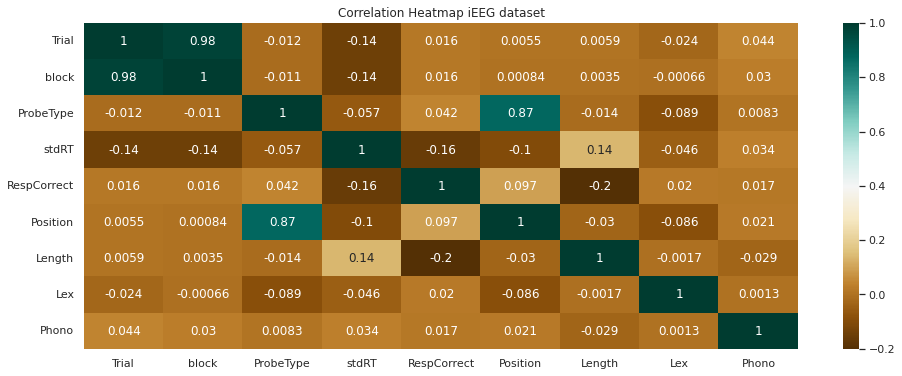

In [295]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


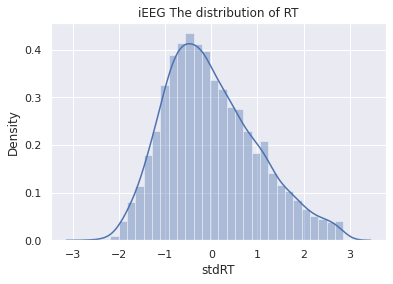

In [72]:
sns.distplot(ieeg_data.stdRT)
pl.title('iEEG The distribution of RT');

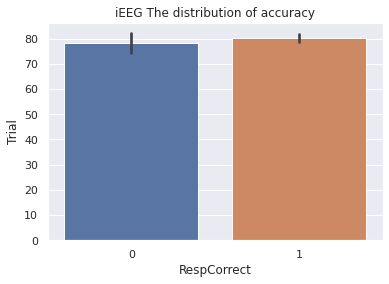

In [73]:
sns.barplot(
    x = 'RespCorrect', y = 'Trial',
    data = ieeg_data
    )
pl.title('iEEG The distribution of accuracy');

**Models**

In [296]:
model_fulli = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.745 	 AIC: 2277.491

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.337

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.993,0.940,1.046,0.027,1095.276,36.584,0.000,***
Lex,0.016,-0.007,0.039,0.012,3317.747,1.364,0.173,
Phono,0.008,-0.015,0.031,0.012,3330.449,0.683,0.494,
Length,-0.031,-0.036,-0.026,0.003,3318.097,-11.904,0.000,***
ProbeType,0.029,0.006,0.052,0.012,3330.187,2.436,0.015,*


In [298]:
model_fulli1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli1.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1146.399 	 AIC: 2292.797

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.937,0.808,1.066,0.066,3220.977,14.262,0.000,***
Lex,0.132,0.034,0.231,0.050,3319.531,2.639,0.008,**
Phono,-0.136,-0.235,-0.036,0.051,3315.895,-2.671,0.008,**
Length,-0.025,-0.043,-0.007,0.009,3313.369,-2.737,0.006,**
ProbeType,0.092,0.018,0.167,0.038,3314.711,2.435,0.015,*
Lex:Phono,0.041,-0.005,0.087,0.024,3319.061,1.736,0.083,.
Lex:Length,0.001,-0.009,0.011,0.005,3311.754,0.197,0.844,
Lex:ProbeType,-0.098,-0.144,-0.052,0.023,3322.411,-4.154,0.000,***
Phono:Length,0.008,-0.003,0.018,0.005,3320.582,1.436,0.151,
Phono:ProbeType,0.052,0.006,0.098,0.024,3312.736,2.210,0.027,*


In [297]:
model_fulli2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli2.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1158.671 	 AIC: 2317.342

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.906,0.712,1.100,0.099,3322.168,9.143,0.000,***
Lex,0.091,-0.143,0.324,0.119,3309.188,0.761,0.447,
Phono,-0.025,-0.258,0.209,0.119,3313.236,-0.208,0.835,
Length,-0.021,-0.050,0.008,0.015,3310.479,-1.411,0.158,
ProbeType,0.113,-0.009,0.235,0.062,3310.329,1.819,0.069,.
Lex:Phono,0.016,-0.175,0.208,0.098,3312.332,0.167,0.867,
Lex:Length,0.010,-0.024,0.043,0.017,3308.996,0.556,0.578,
Lex:ProbeType,-0.069,-0.211,0.073,0.073,3308.994,-0.947,0.344,
Phono:Length,-0.009,-0.044,0.025,0.018,3311.312,-0.533,0.594,
Phono:ProbeType,-0.020,-0.160,0.121,0.072,3310.740,-0.275,0.783,


In [299]:
model_fulli3 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + Lex*Phono*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli3.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+Lex*Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1161.270 	 AIC: 2322.539

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.864,0.645,1.083,0.112,3325.199,7.729,0.000,***
Lex,0.172,-0.132,0.476,0.155,3315.976,1.109,0.267,
Phono,0.054,-0.246,0.353,0.153,3319.287,0.351,0.725,
Length,-0.014,-0.048,0.019,0.017,3310.402,-0.824,0.410,
ProbeType,0.142,0.002,0.282,0.071,3311.578,1.987,0.047,*
Lex:Phono,-0.138,-0.552,0.277,0.212,3325.205,-0.650,0.516,
Lex:Length,-0.004,-0.050,0.043,0.024,3315.508,-0.160,0.873,
Lex:ProbeType,-0.124,-0.318,0.070,0.099,3317.569,-1.252,0.211,
Phono:Length,-0.022,-0.069,0.024,0.024,3317.296,-0.945,0.345,
Phono:ProbeType,-0.071,-0.259,0.116,0.096,3317.572,-0.748,0.455,


**Without match/mismatch**

In [304]:
model_noprobe_i = Lmer(
    'RespCorrect ~ Lex + Phono + Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i.fit()

Formula: RespCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.186 	 AIC: 2276.372

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.037,0.997,1.077,0.020,430.581,50.967,0.000,***
Lex,0.013,-0.009,0.036,0.012,3318.771,1.151,0.250,
Phono,0.008,-0.015,0.031,0.012,3331.334,0.708,0.479,
Length,-0.031,-0.036,-0.026,0.003,3319.051,-11.932,0.000,***


In [305]:
model_noprobe_i1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i1.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1147.874 	 AIC: 2295.747

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.075,1.013,1.138,0.032,1640.731,33.648,0.000,***
Lex,-0.020,-0.090,0.051,0.036,3316.735,-0.547,0.585,
Phono,-0.048,-0.118,0.022,0.036,3323.988,-1.344,0.179,
Length,-0.036,-0.045,-0.027,0.005,3319.286,-7.706,0.000,***
Lex:Phono,0.032,-0.014,0.078,0.023,3322.626,1.350,0.177,
Lex:Length,0.003,-0.008,0.013,0.005,3315.803,0.508,0.611,
Phono:Length,0.007,-0.004,0.017,0.005,3323.930,1.278,0.201,


In [306]:
model_noprobe_i2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i2.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1151.512 	 AIC: 2303.023

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.075,1.003,1.146,0.037,2115.234,29.427,0.000,***
Lex,-0.019,-0.116,0.079,0.050,3315.848,-0.375,0.708,
Phono,-0.047,-0.140,0.047,0.048,3319.285,-0.983,0.326,
Length,-0.036,-0.047,-0.025,0.006,3316.597,-6.539,0.000,***
Lex:Phono,0.030,-0.102,0.161,0.067,3316.658,0.439,0.661,
Lex:Length,0.002,-0.013,0.017,0.008,3315.089,0.322,0.747,
Phono:Length,0.007,-0.008,0.021,0.007,3318.223,0.879,0.379,
Lex:Phono:Length,0.000,-0.020,0.021,0.010,3315.433,0.034,0.973,


**Model with Match vs. Mismatch**

In [78]:
match_i = ieeg_data[ieeg_data['ProbeType'] == 2]
mismatch_i = ieeg_data[ieeg_data['ProbeType'] == 1]

In [80]:
# model for MATCH
model_matchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = match_i
)
model_matchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1575	 Groups: {'Subject': 22.0}

Log-likelihood: -442.880 	 AIC: 885.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.005  0.068
Residual               0.098  0.312

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.145,1.047,1.243,0.050,917.447,22.935,0.000,***
Lex,-0.056,-0.186,0.074,0.066,1551.072,-0.848,0.396,
Phono,-0.080,-0.201,0.040,0.062,1547.936,-1.303,0.193,
Length,-0.044,-0.058,-0.029,0.007,1546.379,-5.938,0.000,***
Lex:Phono,0.049,-0.132,0.229,0.092,1557.925,0.527,0.598,
Lex:Length,-0.000,-0.021,0.020,0.010,1550.400,-0.037,0.970,
Phono:Length,0.016,-0.003,0.035,0.010,1546.957,1.683,0.093,.
Lex:Phono:Length,-0.002,-0.030,0.026,0.014,1554.549,-0.137,0.891,


In [81]:
# model for MISMATCH
model_mismatchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = mismatch_i
)
model_mismatchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1768	 Groups: {'Subject': 22.0}

Log-likelihood: -690.641 	 AIC: 1381.281

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.050
Residual               0.123  0.351

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.998,0.894,1.101,0.053,1373.595,18.932,0.000,***
Lex,0.059,-0.082,0.200,0.072,1744.219,0.823,0.410,
Phono,-0.000,-0.141,0.140,0.072,1752.019,-0.006,0.995,
Length,-0.028,-0.043,-0.012,0.008,1743.511,-3.518,0.000,***
Lex:Phono,-0.046,-0.237,0.145,0.097,1750.809,-0.473,0.636,
Lex:Length,-0.002,-0.024,0.019,0.011,1743.642,-0.208,0.835,
Phono:Length,-0.005,-0.027,0.016,0.011,1750.360,-0.492,0.623,
Lex:Phono:Length,0.013,-0.017,0.042,0.015,1748.157,0.837,0.402,


**Model with Words vs. Non-words**

In [307]:
words_i = ieeg_data[ieeg_data['Lex'] == 1]
nonwords_i = ieeg_data[ieeg_data['Lex'] == 0]

In [308]:
model_wordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = words_i
)
model_wordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -536.078 	 AIC: 1072.155

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.069,0.998,1.139,0.036,678.244,29.560,0.00,***
Phono,0.024,-0.008,0.055,0.016,1652.374,1.478,0.14,
ProbeType,-0.023,-0.055,0.009,0.016,1667.116,-1.407,0.16,
Length,-0.030,-0.037,-0.023,0.004,1650.681,-8.382,0.00,***


In [311]:
model_nonwordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -598.277 	 AIC: 1196.553

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.937,0.865,1.010,0.037,1113.236,25.316,0.000,***
Phono,-0.013,-0.046,0.020,0.017,1662.917,-0.766,0.444,
ProbeType,0.077,0.044,0.110,0.017,1647.180,4.597,0.000,***
Length,-0.032,-0.040,-0.025,0.004,1644.197,-8.590,0.000,***


In [309]:
model_wordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -543.525 	 AIC: 1087.049

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.048,0.885,1.210,0.083,1638.434,12.633,0.000,***
Phono,-0.099,-0.229,0.032,0.067,1648.830,-1.480,0.139,
ProbeType,0.012,-0.086,0.110,0.050,1648.990,0.243,0.808,
Length,-0.020,-0.043,0.004,0.012,1649.822,-1.664,0.096,.
Phono:ProbeType,0.052,-0.012,0.116,0.033,1654.854,1.584,0.113,
Phono:Length,0.008,-0.006,0.023,0.007,1653.450,1.157,0.247,
ProbeType:Length,-0.011,-0.025,0.004,0.007,1650.557,-1.468,0.142,


In [312]:
model_nonwordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -607.418 	 AIC: 1214.835

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.960,0.792,1.128,0.086,1657.786,11.197,0.000,***
Phono,-0.117,-0.256,0.022,0.071,1649.883,-1.653,0.099,.
ProbeType,0.076,-0.026,0.178,0.052,1641.534,1.458,0.145,
Length,-0.030,-0.055,-0.006,0.012,1641.567,-2.435,0.015,*
Phono:ProbeType,0.043,-0.023,0.109,0.034,1646.497,1.264,0.206,
Phono:Length,0.007,-0.008,0.021,0.008,1646.238,0.869,0.385,
ProbeType:Length,-0.004,-0.018,0.011,0.008,1643.009,-0.477,0.633,


In [310]:
model_wordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + Phono*ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+Phono*ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -546.740 	 AIC: 1093.481

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.021,0.814,1.229,0.106,1662.022,9.643,0.000,***
Phono,-0.047,-0.328,0.233,0.143,1659.778,-0.332,0.740,
ProbeType,0.030,-0.101,0.162,0.067,1654.757,0.450,0.653,
Length,-0.015,-0.047,0.016,0.016,1654.607,-0.956,0.339,
Phono:ProbeType,0.016,-0.170,0.202,0.095,1663.565,0.169,0.866,
Phono:Length,-0.000,-0.043,0.043,0.022,1656.136,-0.002,0.998,
ProbeType:Length,-0.014,-0.034,0.007,0.010,1657.826,-1.317,0.188,
Phono:ProbeType:Length,0.006,-0.023,0.035,0.015,1660.467,0.404,0.686,


In [313]:
model_nonwordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -609.664 	 AIC: 1219.327

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.342

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.853,0.630,1.076,0.114,1659.995,7.495,0.000,***
Phono,0.081,-0.224,0.386,0.156,1656.140,0.523,0.601,
ProbeType,0.149,0.006,0.291,0.073,1646.604,2.044,0.041,*
Length,-0.013,-0.047,0.021,0.017,1644.982,-0.733,0.464,
Phono:ProbeType,-0.088,-0.279,0.103,0.097,1654.219,-0.905,0.366,
Phono:Length,-0.026,-0.074,0.021,0.024,1653.910,-1.088,0.277,
ProbeType:Length,-0.015,-0.037,0.006,0.011,1643.360,-1.381,0.168,
Phono:ProbeType:Length,0.022,-0.008,0.051,0.015,1651.487,1.432,0.152,


**Model with H vs. L**

In [101]:
high_i = ieeg_data[ieeg_data['Phono'] == 0]
low_i = ieeg_data[ieeg_data['Phono'] == 1]

In [102]:
model_highi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = high_i
)
model_highi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1545	 Groups: {'Subject': 22.0}

Log-likelihood: -562.410 	 AIC: 1124.820

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.116  0.341

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.866,0.644,1.089,0.114,1536.739,7.632,0.000,***
Lex,0.167,-0.141,0.476,0.158,1527.161,1.063,0.288,
ProbeType,0.141,-0.001,0.282,0.072,1521.881,1.942,0.052,.
Length,-0.014,-0.048,0.020,0.017,1520.551,-0.827,0.408,
Lex:ProbeType,-0.121,-0.318,0.076,0.101,1528.978,-1.204,0.229,
ProbeType:Length,-0.015,-0.036,0.007,0.011,1519.204,-1.309,0.191,
Lex:Length,-0.003,-0.051,0.044,0.024,1526.797,-0.137,0.891,
Lex:ProbeType:Length,0.003,-0.028,0.033,0.016,1528.330,0.179,0.858,


In [103]:
model_lowi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = low_i
)
model_lowi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1798	 Groups: {'Subject': 22.0}

Log-likelihood: -600.396 	 AIC: 1200.791

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.024
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.926,0.724,1.128,0.103,1789.480,8.987,0.000,***
Lex,0.020,-0.258,0.297,0.142,1789.923,0.139,0.890,
ProbeType,0.065,-0.057,0.188,0.063,1783.102,1.044,0.297,
Length,-0.038,-0.070,-0.006,0.016,1784.013,-2.335,0.020,*
Lex:ProbeType,0.003,-0.178,0.183,0.092,1789.652,0.029,0.977,
ProbeType:Length,0.005,-0.014,0.025,0.010,1782.905,0.554,0.580,
Lex:Length,0.025,-0.019,0.069,0.022,1786.272,1.112,0.266,
Lex:ProbeType:Length,-0.016,-0.044,0.013,0.014,1787.854,-1.078,0.281,


## new subj preprocessing and updating iEEG corpus

Converting new subject to the DF format

In [16]:
def get_to_df(data):
  # this function reads into .mat file and creates df out of it for all of the trials of one subject
  # i'm planning on making it more beautiful later

  columns = data[0][1].dtype.names
  df = pd.DataFrame(columns=columns)
  df['Trial'] = np.nan
  df_ = df.copy()
  for i in range(0, data.shape[1]): # for each trial number
    mdtype = data[0][i].dtype
    values = []
    for name in mdtype.names:
      values.append(data[0][i][name])
    values = extra_arrays(values)
    values.append(str(i)) # adding a trial number at the end
    df_.loc[len(df_.index)] = values
  return df_

In [17]:
def extra_arrays(x):
  # elements have nested structure, i.e. arrays inside the arrays
  # below we're getting rid of this depending on the shape of values

  values = []
  for elem in range(0, len(x)):
    var = x[elem]
    var = var[0, 0]
    if var.shape == (1, 1):
      var = var[0, 0]
      values.append(var)
    elif var.shape == (1,):
      values.append(var[0])
    elif var.shape == (1, 5):
      var = var.tolist()[0]
      values.append(var)
    elif var.shape == (5, 1):
      new = []
      for i in var:
        i = i[0]
        new.append(i)
      values.append(new)
    else:
      values.append(var)
  return values

In [18]:
subj_df = get_to_df(new_subject['trialInfo'])
subj_df['Subject'] = 'D72'

In [23]:
subj_df.columns

Index(['block', 'ProbeType', 'ProbeTypeName', 'StimlusCategory',
       'ReactionTime', 'KeyCode', 'Resp', 'RespCorrect', 'Omission',
       'stimulusAudioStart', 'stimulusAlignedTrigger', 'probeAudioStart',
       'probeAlignedTrigger', 'TriggerValue', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'ListenCueTime', 'MaintenancePeriodTime',
       'ProbeCueTime', 'Trial', 'Subject'],
      dtype='object')

In [34]:
# no response 
new_s = subj_df[subj_df['Resp'] != 'No Response']
new_s = new_s[[
               'block', 'Trial', 'ProbeType',
               'Subject', 'ReactionTime', 'StimlusCategory',
               'RespCorrect', 'Omission', 'stimulusSounds_idx',
               'ProbeCategory', 'probeSound_idx' 

]]

In [36]:
new_probe = []
for i in new_s.ProbeCategory.values:
  new_probe.append(i.lower())
new_s['ProbeCategory'] = new_probe

In [51]:
# making values in df more 'handy'
whole_list = new_s['stimulusSounds_idx'].values
new_sound_idx = []
for i in whole_list:
  if type(i) is list:
    new_sound_idx.append(i)
  else:
    new_sound_idx.append(i.tolist()[0])
new_s['stimulusSounds_idx'] = new_sound_idx 

In [54]:
compare = []
for i in new_sound_idx:
  length = len(i)
  if length not in compare:
    compare.append(length)
print(compare)

[5, 7, 9, 3]


In [57]:
# calculating relative position of the word in the list
# pos for only in seqence trials: probe sound index and stimulus sound index
# beginning middle or end
positions = [] # for the new 'position' column in df
# 1 - beginning, 2 - middle, 3 - end
ind = new_s['probeSound_idx'].values
in_out = new_s['ProbeType'].values
for i in range(0, len(ind)):
  if in_out[i] == 2: # if it is in sequence
    if ind[i] in new_sound_idx[i]:
      # for length of the list 3
      if len(new_sound_idx[i]) == 3:
        if new_sound_idx[i].index(ind[i]) == 0:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 1:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(3) # end
      
      # for length of the list 5
      ## revise!
      elif len(new_sound_idx[i]) == 5:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) == 2:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [3, 4]:
          positions.append(3) # end

      # for length of the list 7
      elif len(new_sound_idx[i]) == 7:
        if new_sound_idx[i].index(ind[i]) in [0, 1]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [2, 3, 4]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [5, 6]:
          positions.append(3) # end
      
      # for length of the list 9
      elif len(new_sound_idx[i]) == 9:
        if new_sound_idx[i].index(ind[i]) in [0, 1, 2]:
          positions.append(1) # beginning 
        elif new_sound_idx[i].index(ind[i]) in [3, 4, 5]:
          positions.append(2) # middle
        elif new_sound_idx[i].index(ind[i]) in [6, 7, 8]:
          positions.append(3) # end
    else:
      print('Check', i)
      break  
  elif in_out[i] == 1:
    positions.append(0) # if it is out of sequence it is not in the list
  else:
    print('Check', i)
    break

In [58]:
length = []
for i in new_s.stimulusSounds_idx:
  length.append(len(i))

In [59]:
new_s['Position'] = positions
new_s['Length'] = length

In [65]:
lex = []
phon = []
for i in new_s.ProbeCategory.values:
  if 'non-words' in i: # non - words = 0, words = 0
    lex.append(0)
  elif 'words' in i:
    lex.append(1)
for i in new_s.ProbeCategory.values:
  if 'low' in i: # high = 0 low = 1 
    phon.append(1)
  elif 'high' in i:
    phon.append(0)
print(len(lex))
print(len(phon))

157
157


In [66]:
new_s['Lex'] = lex
new_s['Phono'] = phon

In [94]:
# conactenate new subject to existing data frame
ieeg_extended = pd.concat([ieeg_extended, new_s])

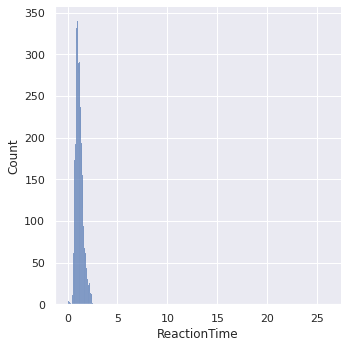

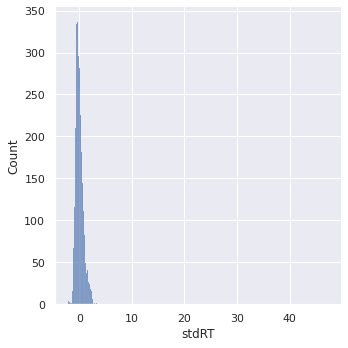

In [97]:
sns.displot(ieeg_extended['ReactionTime'])
#pl.xlim([0, 3]);
sns.displot(ieeg_extended['stdRT']);

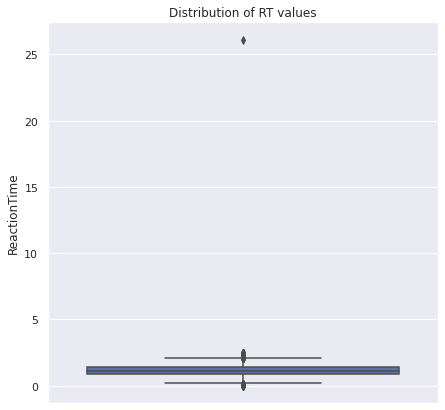

In [98]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_extended)
pl.title("Distribution of RT values");

In [99]:
# check for outliers outside 
# given that we have a new subject now
# the ieeg_extended with outliers
ieeg_ = ieeg_extended.copy()
q75 = np.percentile(ieeg_extended['ReactionTime'], 75)
q25 = np.percentile(ieeg_extended['ReactionTime'], 25)
inter_qr = q75 - q25
upper = q75 + (inter_qr*1.5)
lower = q25 - (inter_qr*1.5)
col_new = []
for value in ieeg_extended['ReactionTime'].values:
  if value < lower:
    col_new.append(np.nan)
  elif value > upper:
    col_new.append(np.nan)
  else:
    col_new.append(value)
ieeg_['ReactionTime'] = col_new

In [102]:
ieeg_[ieeg_['ReactionTime'].isna()].Subject.unique()

array(['D23', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31', 'D33', 'D36',
       'D38', 'D39', 'D41', 'D42', 'D47', 'D48', 'D53', 'D54', 'D55',
       'D61', 'D63', 'D65', 'D68', 'D69', 'D70', 'D72'], dtype=object)

In [103]:
print(ieeg_.isnull().sum()['ReactionTime'])
# drop outliers
ieeg_ = ieeg_.dropna()
print(ieeg_.isnull().sum()['ReactionTime'])

149
0


In [104]:
rt = ieeg_.ReactionTime.values
ieeg_['stdRT'] = (rt -rt.mean())/rt.std()

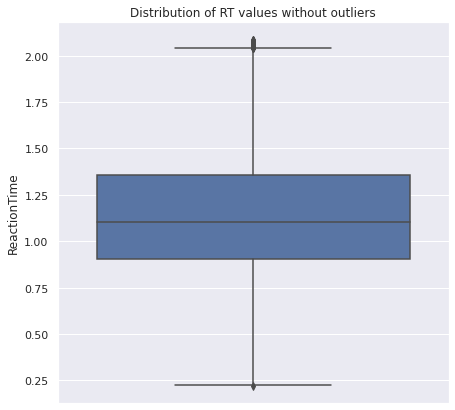

In [105]:
pl.figure(figsize = (7, 7))
ax = sns.boxplot(y="ReactionTime", data=ieeg_)
pl.title("Distribution of RT values without outliers");

<Figure size 1440x720 with 0 Axes>

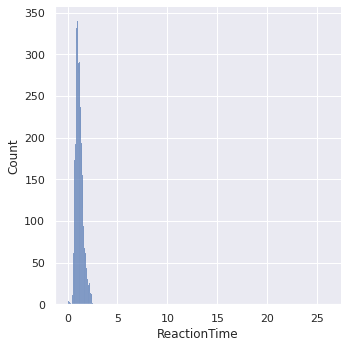

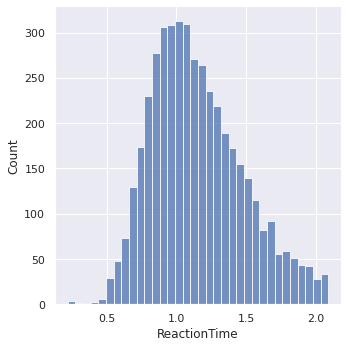

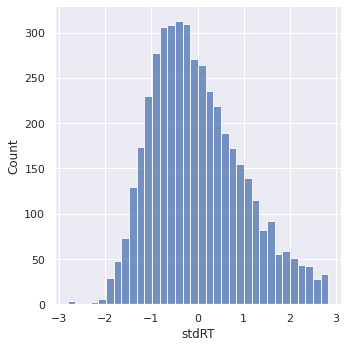

In [106]:
# upper plot - with outliers, lower plot - without
pl.figure(figsize = (20, 10))
sns.displot(ieeg_extended['ReactionTime']);
sns.displot(ieeg_['ReactionTime']);
sns.displot(ieeg_['stdRT']);

## Plotting updated ieeg dataset

In [107]:
checkset = ieeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
(checkset < 0.75).any()

RespCorrect    True
dtype: bool

In [108]:
options_drop = checkset[checkset['RespCorrect'] < 0.75].index
checkset = checkset.reset_index()

print('The subjects with accuracy less than 75 %')
print(options_drop)
x = []
for i in checkset.Subject.values:
  for j in options_drop:
    if i == j:
      x.append(checkset.loc[checkset['Subject'] == i][['RespCorrect']].values[0][0])
print(x)

The subjects with accuracy less than 75 %
Index(['D33', 'D49', 'D61', 'D65'], dtype='object', name='Subject')
[0.6973684210526315, 0.6470588235294118, 0.6814814814814815, 0.7285714285714285]


In [109]:
# drop the subjects who are not 75 % accurate
ieeg_short = ieeg_.copy()
for i in options_drop:
  ieeg_short = ieeg_short[ieeg_short['Subject'] != i]

In [111]:
# we end up with 26 subjects
print(len(ieeg_short.Subject.unique()))
print(len(ieeg_.Subject.unique()))

26
30


In [134]:
print(ieeg_.shape)
print(ieeg_short.shape)

(4461, 16)
(3881, 16)


In [114]:
match_ = ieeg_[ieeg_['ProbeType'] == 2]
mismatch_ = ieeg_[ieeg_['ProbeType'] == 1]
match_short = ieeg_short[ieeg_short['ProbeType'] == 2]
mismatch_short = ieeg_short[ieeg_short['ProbeType'] == 1]

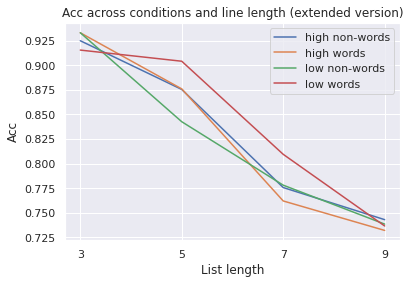

In [112]:
pl.figure()
subset = ieeg_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length (extended version)');

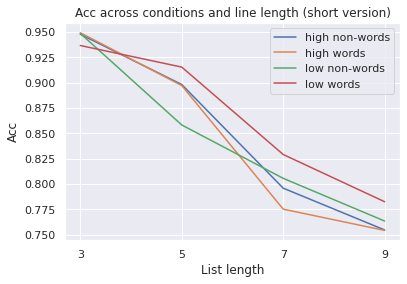

In [113]:
pl.figure()
subset = ieeg_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length (short version)');

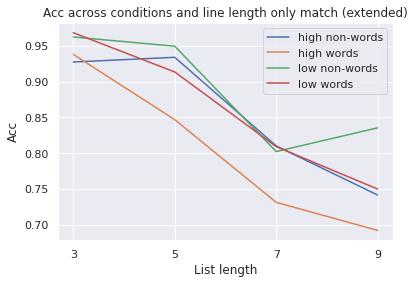

In [115]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (extended)');

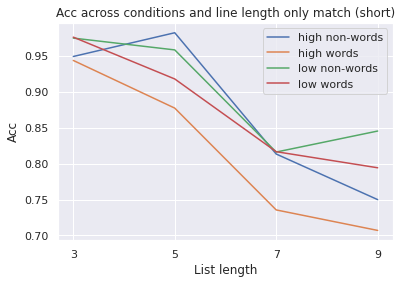

In [116]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (short)');

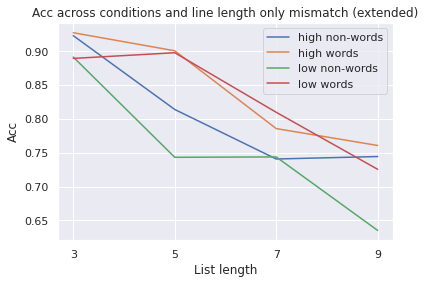

In [117]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (extended)');

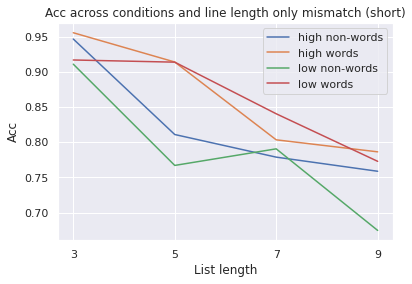

In [118]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (short)');

## Modeling updated iEEG dataset

In [140]:
ieeg_short.head()

,Trial,block,ProbeType,probeSound_idx,StimlusCategory,ReactionTime,RespCorrect,Omission,ProbeCategory,stimulusSounds_idx,Position,Length,stdRT,Lex,Phono,Subject
0,0,1,2,29,Low Words,0.857518,1,Responded,low words,"[29, 25, 30]",1,3,-0.890894,1,1,D23
1,1,1,2,5,High Words,1.339604,1,Responded,high words,"[2, 5, 8, 4, 7, 10, 3]",1,7,0.570656,1,0,D23
2,2,1,2,16,High Non-Words,1.045657,1,Responded,high non-words,"[19, 14, 18, 16, 20, 15, 17]",2,7,-0.320511,0,0,D23
3,3,1,1,29,High Words,1.497001,1,Responded,low words,"[10, 2, 7, 9, 1, 8, 6, 5, 4]",0,9,1.047839,1,1,D23
4,4,1,1,9,Low Words,1.679783,1,Responded,high words,"[30, 24, 25, 29, 21]",0,5,1.601984,1,0,D23


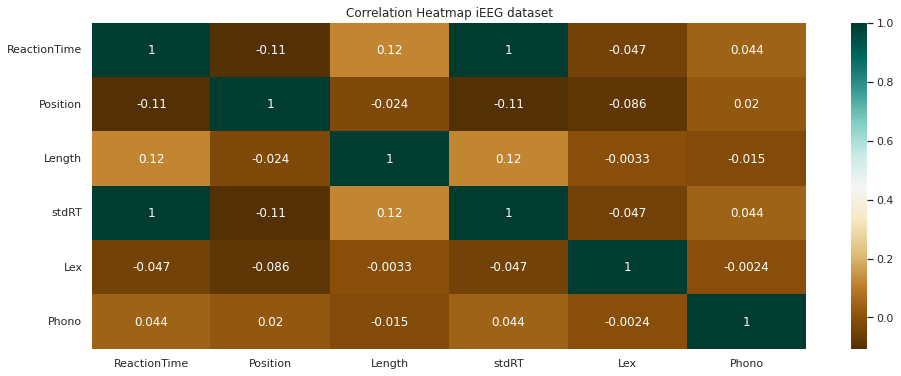

In [141]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_short.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


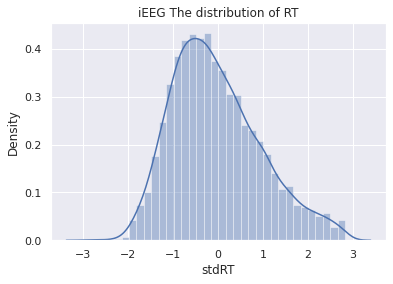

In [142]:
sns.distplot(ieeg_short.stdRT)
pl.title('iEEG The distribution of RT');

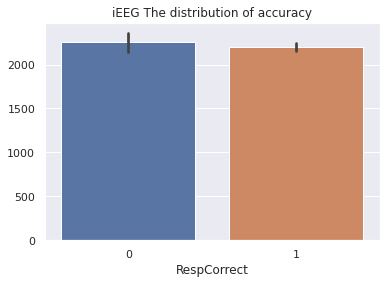

In [154]:
sns.barplot(
    x = ieeg_short.RespCorrect,
    y = ieeg_short.index
)
pl.title('iEEG The distribution of accuracy');

In [272]:
ieeg_short.RespCorrect = ieeg_short.RespCorrect.astype('int64')
ieeg_short.ProbeType = ieeg_short.ProbeType.astype('int64')
ieeg_short.Trial = ieeg_short.Trial.astype('int64')

In [276]:
ieeg_sh = ieeg_short[[
                      'Trial', 'Subject', 'block', 'ProbeType',
                      'stdRT', 'RespCorrect', 'Position',
                      'Length', 'Lex', 'Phono'
]]

**Full model**

In [277]:
model_main = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1423.027 	 AIC: 2846.055

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.346

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.979,0.928,1.029,0.026,1176.390,37.921,0.000,***
Phono,0.008,-0.014,0.030,0.011,3868.987,0.713,0.476,
Lex,0.013,-0.009,0.035,0.011,3851.582,1.134,0.257,
Length,-0.032,-0.037,-0.027,0.002,3852.451,-12.727,0.000,***
ProbeType,0.035,0.013,0.057,0.011,3867.183,3.102,0.002,**


In [278]:
model_main1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main1.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1429.026 	 AIC: 2858.051

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.941,0.819,1.063,0.062,3711.155,15.140,0.000,***
Phono,-0.144,-0.238,-0.049,0.048,3853.568,-2.987,0.003,**
Lex,0.144,0.051,0.237,0.048,3857.496,3.027,0.002,**
Length,-0.028,-0.045,-0.011,0.009,3849.864,-3.214,0.001,**
ProbeType,0.081,0.010,0.151,0.036,3851.483,2.246,0.025,*
Phono:Lex,0.036,-0.008,0.080,0.022,3853.520,1.605,0.109,
Phono:Length,0.007,-0.003,0.017,0.005,3857.940,1.371,0.170,
Phono:ProbeType,0.062,0.018,0.106,0.022,3846.963,2.751,0.006,**
Lex:Length,-0.000,-0.010,0.010,0.005,3845.376,-0.034,0.973,
Lex:ProbeType,-0.100,-0.144,-0.056,0.022,3863.596,-4.479,0.000,***


In [302]:
model_main2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Lex*ProbeType + Phono*Length*ProbeType + Length*Lex*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main2.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Lex*ProbeType+Phono*Length*ProbeType+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1441.279 	 AIC: 2882.558

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.928,0.745,1.112,0.094,3856.936,9.927,0.000,***
Phono,-0.044,-0.265,0.178,0.113,3848.855,-0.388,0.698,
Lex,0.072,-0.148,0.292,0.112,3842.474,0.640,0.522,
Length,-0.026,-0.054,0.002,0.014,3844.513,-1.817,0.069,.
ProbeType,0.086,-0.029,0.202,0.059,3844.205,1.469,0.142,
Phono:Lex,0.025,-0.156,0.207,0.093,3845.880,0.272,0.785,
Phono:Length,-0.011,-0.043,0.022,0.017,3847.328,-0.628,0.530,
Phono:ProbeType,0.002,-0.132,0.136,0.068,3844.525,0.029,0.977,
Lex:Length,0.011,-0.021,0.043,0.016,3843.010,0.669,0.504,
Lex:ProbeType,-0.047,-0.181,0.088,0.069,3842.848,-0.679,0.497,


In [303]:
model_main3 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Length*ProbeType + Phono*Lex*ProbeType + Length*Lex*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main3.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Length*ProbeType+Phono*Lex*ProbeType+Length*Lex*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1444.155 	 AIC: 2888.310

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.905,0.699,1.112,0.106,3862.215,8.577,0.000,***
Phono,-0.001,-0.286,0.283,0.145,3854.139,-0.008,0.994,
Lex,0.116,-0.171,0.403,0.147,3850.276,0.791,0.429,
Length,-0.022,-0.054,0.010,0.016,3845.105,-1.348,0.178,
ProbeType,0.102,-0.031,0.234,0.068,3845.693,1.509,0.131,
Phono:Lex,-0.058,-0.452,0.336,0.201,3861.161,-0.289,0.772,
Phono:Length,-0.018,-0.062,0.027,0.023,3852.295,-0.779,0.436,
Phono:ProbeType,-0.026,-0.205,0.152,0.091,3851.973,-0.288,0.773,
Lex:Length,0.004,-0.041,0.048,0.023,3850.858,0.165,0.869,
Lex:ProbeType,-0.076,-0.260,0.107,0.094,3852.279,-0.815,0.415,


**Without match/mismatch**

In [281]:
model_noprobe = Lmer(
    'RespCorrect ~ Phono + Lex + Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe.fit()

Formula: RespCorrect~Phono+Lex+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1424.260 	 AIC: 2848.520

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.031,0.993,1.070,0.019,458.699,53.048,0.000,***
Phono,0.008,-0.014,0.030,0.011,3869.833,0.749,0.454,
Lex,0.010,-0.012,0.032,0.011,3852.468,0.877,0.380,
Length,-0.032,-0.037,-0.027,0.002,3853.421,-12.733,0.000,***


In [282]:
model_noprobe1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe1.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1434.460 	 AIC: 2868.919

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.062,1.002,1.121,0.030,1777.286,34.999,0.000,***
Phono,-0.042,-0.108,0.025,0.034,3862.114,-1.226,0.220,
Lex,-0.011,-0.079,0.056,0.034,3850.316,-0.334,0.739,
Length,-0.036,-0.044,-0.027,0.004,3854.924,-7.956,0.000,***
Phono:Lex,0.026,-0.018,0.070,0.022,3857.134,1.159,0.246,
Lex:Length,0.001,-0.009,0.011,0.005,3849.525,0.243,0.808,
Phono:Length,0.006,-0.004,0.016,0.005,3861.781,1.234,0.217,


In [283]:
model_noprobe2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + Phono*Lex*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe2.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+Phono*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1438.100 	 AIC: 2876.201

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.057,0.989,1.125,0.035,2328.100,30.480,0.000,***
Phono,-0.032,-0.122,0.057,0.046,3859.036,-0.714,0.475,
Lex,-0.002,-0.094,0.090,0.047,3850.125,-0.037,0.971,
Length,-0.035,-0.045,-0.024,0.005,3853.562,-6.602,0.000,***
Phono:Lex,0.008,-0.118,0.133,0.064,3852.169,0.121,0.904,
Lex:Length,-0.000,-0.015,0.014,0.007,3849.735,-0.054,0.957,
Phono:Length,0.005,-0.009,0.019,0.007,3857.332,0.654,0.513,
Phono:Lex:Length,0.003,-0.017,0.023,0.010,3850.998,0.303,0.762,


**Words vs. Non-words**

In [286]:
words_ieeg = ieeg_sh[ieeg_sh['Lex'] == 1]
nonwords_ieeg = ieeg_sh[ieeg_sh['Lex'] == 0]

In [287]:
model_words_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -684.055 	 AIC: 1368.111

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.057
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.059,0.991,1.127,0.035,735.395,30.644,0.000,***
Phono,0.021,-0.009,0.052,0.015,1917.777,1.375,0.169,
Length,-0.031,-0.038,-0.025,0.003,1914.643,-9.112,0.000,***
ProbeType,-0.019,-0.050,0.012,0.016,1936.348,-1.209,0.227,


In [288]:
model_nonwords_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -734.341 	 AIC: 1468.682

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.914,0.846,0.983,0.035,1385.438,26.262,0.000,***
Phono,-0.010,-0.042,0.021,0.016,1933.975,-0.642,0.521,
Length,-0.032,-0.039,-0.025,0.004,1911.127,-8.950,0.000,***
ProbeType,0.085,0.053,0.116,0.016,1920.102,5.312,0.000,***


In [289]:
model_words_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -691.498 	 AIC: 1382.996

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.048,0.893,1.203,0.079,1893.692,13.256,0.000,***
Phono,-0.104,-0.228,0.020,0.063,1914.297,-1.639,0.101,
Length,-0.023,-0.045,-0.000,0.011,1915.922,-1.988,0.047,*
ProbeType,0.009,-0.084,0.102,0.048,1914.629,0.189,0.850,
Phono:Length,0.009,-0.005,0.022,0.007,1918.038,1.246,0.213,
Phono:ProbeType,0.052,-0.009,0.114,0.031,1920.044,1.669,0.095,.
Length:ProbeType,-0.010,-0.023,0.004,0.007,1916.559,-1.368,0.172,


In [290]:
model_nonwords_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -742.846 	 AIC: 1485.692

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.978,0.820,1.136,0.080,1929.447,12.151,0.000,***
Phono,-0.131,-0.263,0.000,0.067,1921.011,-1.953,0.051,.
Length,-0.034,-0.057,-0.011,0.012,1909.123,-2.902,0.004,**
ProbeType,0.052,-0.044,0.148,0.049,1908.820,1.056,0.291,
Phono:Length,0.005,-0.010,0.019,0.007,1921.560,0.633,0.527,
Phono:ProbeType,0.062,-0.001,0.125,0.032,1914.186,1.936,0.053,.
Length:ProbeType,-0.000,-0.014,0.014,0.007,1910.547,-0.005,0.996,


In [291]:
model_words_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -694.611 	 AIC: 1389.223

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.006,0.808,1.203,0.101,1926.777,9.979,0.000,***
Phono,-0.021,-0.289,0.246,0.137,1925.801,-0.155,0.877,
Length,-0.016,-0.046,0.015,0.015,1920.836,-1.014,0.311,
ProbeType,0.038,-0.087,0.163,0.064,1920.339,0.594,0.553,
Phono:Length,-0.005,-0.047,0.037,0.021,1921.109,-0.237,0.812,
Phono:ProbeType,-0.006,-0.183,0.171,0.090,1929.686,-0.062,0.951,
Length:ProbeType,-0.014,-0.034,0.005,0.010,1923.949,-1.447,0.148,
Phono:Length:ProbeType,0.010,-0.018,0.037,0.014,1925.598,0.682,0.495,


In [292]:
model_nonwords_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -745.447 	 AIC: 1490.893

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.122  0.350

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.893,0.684,1.103,0.107,1929.931,8.359,0.000,***
Phono,0.026,-0.262,0.314,0.147,1926.240,0.177,0.860,
Length,-0.020,-0.053,0.012,0.017,1913.759,-1.225,0.221,
ProbeType,0.109,-0.025,0.243,0.068,1914.862,1.595,0.111,
Phono:Length,-0.022,-0.066,0.023,0.023,1924.149,-0.942,0.346,
Phono:ProbeType,-0.042,-0.223,0.139,0.092,1923.726,-0.456,0.648,
Length:ProbeType,-0.010,-0.030,0.011,0.011,1911.326,-0.893,0.372,
Phono:Length:ProbeType,0.017,-0.011,0.045,0.014,1920.794,1.202,0.230,


## Investigation

In [314]:
# wanna check is there any difference depending on the part of experiment
# beginning of the experiment vs. the end 

In [327]:
trial_category = []
for i in eeg_data.Subject.unique():
  subset = eeg_data[eeg_data['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [332]:
eeg_data['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [333]:
eeg_data.head()

,Trial,Subject,Block,ProbeType,stdRT,ResponseCorrect,Position,Length,Lex,Phono,TrialPos
0,1,E2,1,2,0.535034,1,3,5,0,1,beginning
1,2,E2,1,2,-0.366749,1,3,9,1,1,beginning
2,3,E2,1,2,1.474424,1,1,5,1,0,beginning
3,4,E2,1,1,0.234390,1,0,7,0,0,beginning
4,5,E2,1,2,1.405773,1,1,9,0,0,beginning


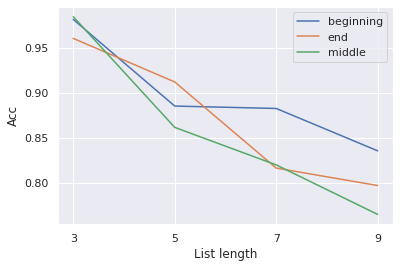

In [336]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

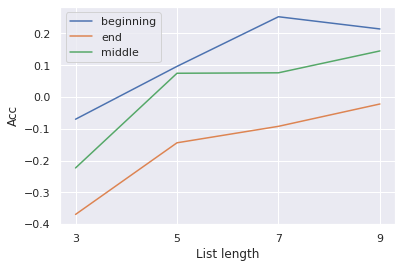

In [338]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());